In [ ]:
ls drive/MyDrive/'Colab Notebooks'/input

holidays_events.csv  sample_submission.csv  test.csv   transactions.csv
oil.csv              stores.csv             train.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing

import seaborn as sns
%matplotlib inline
np.random.seed(2)

pd.set_option('display.max_columns', None) # Show all columns
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/input/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/input/test.csv')
holidays_events = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/input/holidays_events.csv')
oil = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/input/oil.csv')
stores = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/input/stores.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/input/transactions.csv').sort_values(["store_nbr", "date"])
# Convert to datetime type
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)

train # date 20130101~20170815, store_nbr 55 types, family 33 types, 3000888 raws

id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 6 columns]

In [ ]:
test # date 20170816~20170831 28512 raws

id       date  store_nbr                      family  onpromotion
0      3000888 2017-08-16          1                  AUTOMOTIVE            0
1      3000889 2017-08-16          1                   BABY CARE            0
2      3000890 2017-08-16          1                      BEAUTY            2
3      3000891 2017-08-16          1                   BEVERAGES           20
4      3000892 2017-08-16          1                       BOOKS            0
...        ...        ...        ...                         ...          ...
28507  3029395 2017-08-31          9                     POULTRY            1
28508  3029396 2017-08-31          9              PREPARED FOODS            0
28509  3029397 2017-08-31          9                     PRODUCE            1
28510  3029398 2017-08-31          9  SCHOOL AND OFFICE SUPPLIES            9
28511  3029399 2017-08-31          9                     SEAFOOD            0

[28512 rows x 5 columns]

In [ ]:
# Check train & test data havn't null value
train_null = train.isnull().sum()
test_null = test.isnull().sum()
print(train_null, test_null, sep='\n\n')

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64


In [ ]:
round(train.iloc[:,1:].describe(),2)

store_nbr       sales  onpromotion
count  3000888.00  3000888.00   3000888.00
mean        27.50      357.78         2.60
std         15.59     1102.00        12.22
min          1.00        0.00         0.00
25%         14.00        0.00         0.00
50%         27.50       11.00         0.00
75%         41.00      195.85         0.00
max         54.00   124717.00       741.00

In [ ]:
print('The number of the family: {}'.format(len(train['family'].unique())))
print(train['family'].unique())
print()
print('The number of the store_nbr: {}'.format(len(train['store_nbr'].unique())))
print(train['store_nbr'].unique())

The number of the family: 33
['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']

The number of the store_nbr: 54
[ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]


## What does data look like?

In [ ]:
def show_data(data, title):
  print('==={}==='.format(title))
  print(data.head(5))
  print()
show_data(holidays_events, 'Holidays_events') # Pay special attention to the transferred column
show_data(oil, 'Oil')
show_data(stores, 'Stores')
show_data(transactions, 'Transactions')
# Holidays_events is so complicated that we would not use it

===Holidays_events===
         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  

===Oil===
         date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

===Stores===
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       1

## Oil

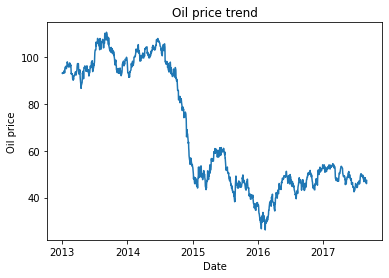

In [ ]:
import matplotlib.ticker as ticker
oil['date'] = pd.to_datetime(oil.date)
plt.title("Oil price trend")
plt.xlabel("Date")
plt.ylabel("Oil price")
sns.lineplot(data=oil, x="date", y="dcoilwtico")
# Oil prices are relatively stable compared to previous years

## Transactions

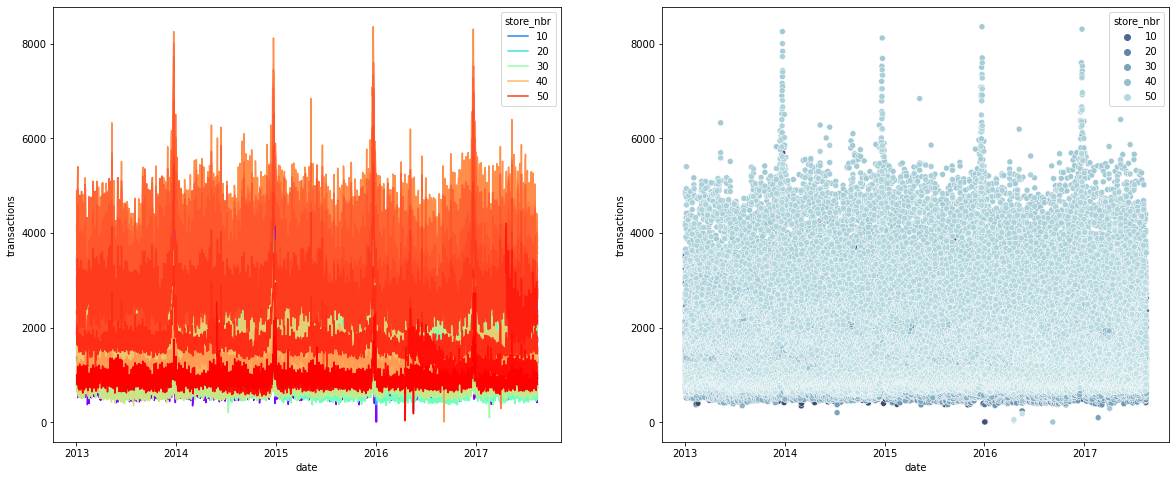

In [ ]:
transactions['date'] = pd.to_datetime(transactions.date)
f, axes = plt.subplots(1, 2, figsize=(20,8))
sns.lineplot(data=transactions, x = 'date', y = 'transactions', hue = 'store_nbr',palette='rainbow', ax=axes[0])
sns.scatterplot(data=transactions, x = 'date', y = 'transactions', hue = 'store_nbr',palette="ch:r=-.2,d=.3_r", ax=axes[1])
# Every December is the peak period of trading

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


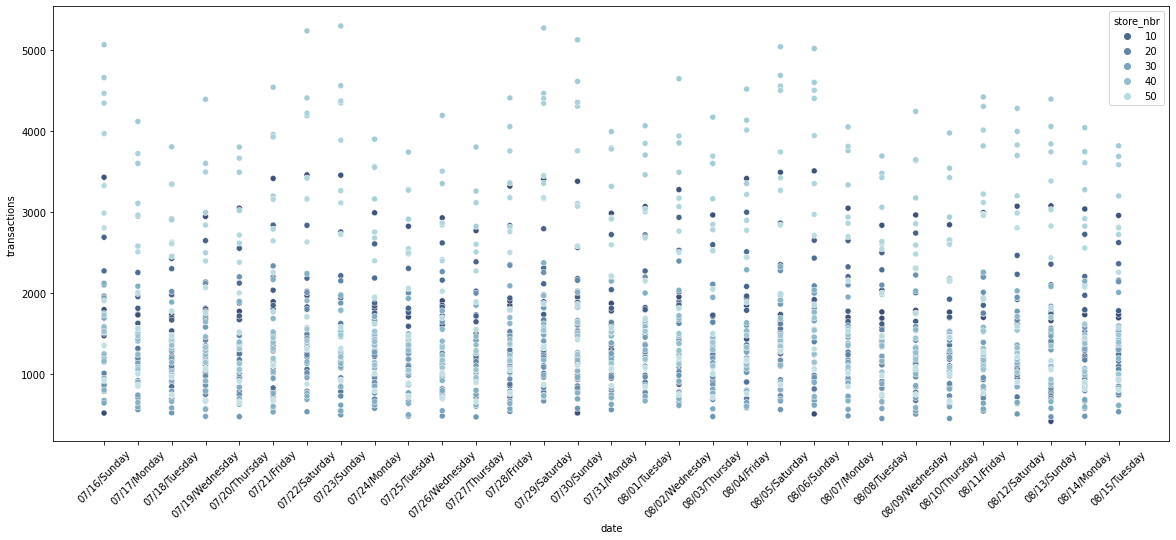

In [ ]:
train_a_month = transactions.loc[transactions.date >= '2017-07-16']
f, axes = plt.subplots(figsize=(20,8))
train_a_month['date'] = train_a_month.date.dt.strftime('%m/%d/%A')
axes.set_xticklabels(labels=train_a_month['date'], rotation=45)
sns.scatterplot(data=train_a_month, x = 'date', y = 'transactions', hue = 'store_nbr',palette="ch:r=-.2,d=.3_r", ax=axes)
# x_dates = train_a_month['date'].dt.day_name()
# print(x_dates)
# axes.set_xticklabels(labels=x_dates)
# Compared to weekdays, weekends have more transactions

## Stores

Count  cluster
Type                
A         9      111
B         8       62
C        15      122
D        18      123
E         4       40

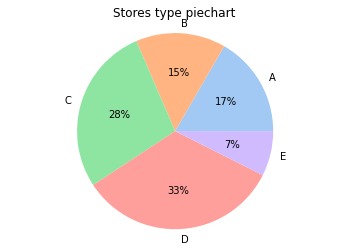

In [ ]:
colors = sns.color_palette('pastel')
stores_1 = stores['type'].value_counts().rename_axis('Type').to_frame('Count').sort_values(by = 'Type')
stores_2 = stores[['type','cluster']].groupby('type').sum()
stores_show = pd.merge(stores_1, stores_2, left_index=True, right_index=True)
plt.pie(stores_show['Count'], labels = stores_show.index, colors = colors, autopct='%.0f%%')
plt.axis('equal')
plt.title('Stores type piechart')
stores_show

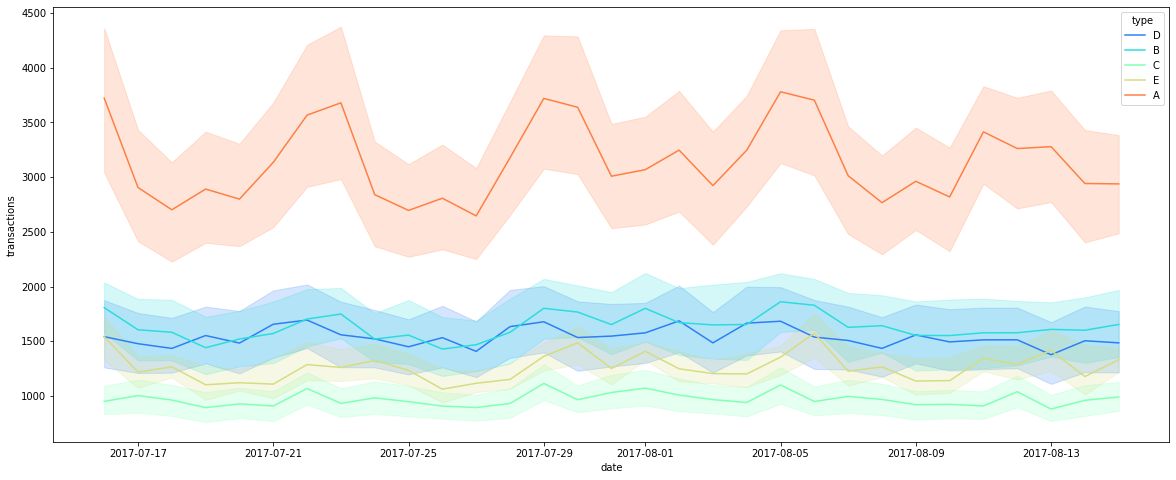

In [ ]:
trade_a_month = pd.merge(transactions.loc[transactions.date >= '2017-07-16'], stores[['store_nbr','type','cluster']]).sort_values(['date', 'store_nbr'])
trade_a_month
f, axes = plt.subplots(figsize=(20,8))
sns.lineplot(data=trade_a_month, x = 'date', y = 'transactions', hue = 'type',palette='rainbow', ax=axes)
# Type A has the most numbers of trancations in last month

## Model

## Average the number of transactions in the last three weeks to predict

In [ ]:
import numpy  as np
import pandas as pd


# create a 'day of the week' feature
train['day_of_the_week'] = train['date'].dt.day_name()
test['day_of_the_week']  = test['date'].dt.day_name()

# select the very last three weeks of the training data
train_three_weeks = train.query("date >= '2017-07-26' ")

def exp_mean_ln(df):
    return np.expm1(np.mean(np.log1p(df['sales'])))

# calculate the average values
train_average = train_three_weeks.groupby(['store_nbr','family','day_of_the_week']).apply(exp_mean_ln).to_dict()
test['sales'] = test.set_index(['store_nbr','family','day_of_the_week']).index.map(train_average.get)

# create and write out the submission.csv file
submission = pd.DataFrame({'id': test.id, 'sales': test.sales})
submission.to_csv('submission.csv', index=False)

## RNN

In [ ]:
train = train.query("date>'2017-6-1'")
tmp_train = train.groupby('family')
tmp_test = test.groupby('family')

In [ ]:
def build_to_train_data(train_df,pDays=60,fDays=16):
    x_train = []
    y_train = []

    for i in range(len(train_df)-pDays-fDays):
        x_train.append(np.array(train_df[i:i+pDays]))
        y_train.append(np.array(train_df[i+pDays:i+pDays+fDays]))
    return np.array(x_train), np.array(y_train)

def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

def build_model(shape):
    model = Sequential()
    model.add(LSTM(50, input_length=shape[1], input_dim=shape[2]))
    #
    model.add(RepeatVector(2))
    model.add(LSTM(50))
    #
    
    model.add(RepeatVector(2))
    model.add(LSTM(50))
    # output shape: (1, 1)
    model.add(Dense(54))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

In [ ]:
result = {}
pass_days = 3

for family in tmp_train.groups.keys():
    df1 = tmp_train.get_group(family)
    tmp_df2 = pd.DataFrame(columns=list(range(1,55)))
    
    for i in df1['date'].unique():
        filter = df1['date']==i
        tmp_df1 = df1[filter].sort_values('store_nbr').set_index('store_nbr')
        
        tmp_df2.loc[i] = list(tmp_df1['sales'])

    sc = MinMaxScaler(feature_range = (0, 1))

    X, Y = build_to_train_data(sc.fit_transform(tmp_df2), pass_days,1)
    X, Y = shuffle(X,Y)

    X_train = X[int(len(X)*0.1):]
    Y_train = Y[int(len(X)*0.1):]
    X_val = X[:int(len(X)*0.1)]
    Y_val = Y[:int(len(X)*0.1):]

    model = build_model(X_train.shape)
    callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
    model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])
    

    test_df = tmp_df2[pass_days*-1:]
    for i in range(16):
        x_test = []
        x_test.append(np.array(test_df[i:i + pass_days]))
        ans = model.predict(np.array(x_test))

        tmp_time = test_df.index[-1] + timedelta(days=1)
        test_df.loc[tmp_time] = list(ans[0])
    
    tarr = test_df[-16:]
    tdf = pd.DataFrame(sc.inverse_transform(tarr),index=list(test_df[-16:].index),columns=list(test_df[-16:].head(0)))
    rdf = test.groupby('family').get_group(family)


    for i in range(len(rdf)):
        id = rdf.iloc[i]['id']
        date = rdf.iloc[i]['date']
        store_nbr = rdf.iloc[i]['store_nbr']
        result[id] = tdf.loc[date][store_nbr]

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_99 (LSTM)              (None, 50)                21000     
                                                                 
 repeat_vector_66 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_100 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_67 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_101 (LSTM)             (None, 50)                20200     
                                                                 
 dense_33 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_102 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_68 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_103 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_69 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_104 (LSTM)             (None, 50)                20200     
                                                                 
 dense_34 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_105 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_70 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_106 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_71 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_107 (LSTM)             (None, 50)                20200     
                                                                 
 dense_35 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_108 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_72 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_109 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_73 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_110 (LSTM)             (None, 50)                20200     
                                                                 
 dense_36 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_111 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_74 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_112 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_75 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_113 (LSTM)             (None, 50)                20200     
                                                                 
 dense_37 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_114 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_76 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_115 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_77 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_116 (LSTM)             (None, 50)                20200     
                                                                 
 dense_38 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_117 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_78 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_118 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_79 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_119 (LSTM)             (None, 50)                20200     
                                                                 
 dense_39 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_120 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_80 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_121 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_81 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_122 (LSTM)             (None, 50)                20200     
                                                                 
 dense_40 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_123 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_82 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_124 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_83 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_125 (LSTM)             (None, 50)                20200     
                                                                 
 dense_41 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_126 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_84 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_127 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_85 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_128 (LSTM)             (None, 50)                20200     
                                                                 
 dense_42 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_129 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_86 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_130 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_87 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_131 (LSTM)             (None, 50)                20200     
                                                                 
 dense_43 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_132 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_88 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_133 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_89 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_134 (LSTM)             (None, 50)                20200     
                                                                 
 dense_44 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_135 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_90 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_136 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_91 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_137 (LSTM)             (None, 50)                20200     
                                                                 
 dense_45 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_138 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_92 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_139 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_93 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_140 (LSTM)             (None, 50)                20200     
                                                                 
 dense_46 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_141 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_94 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_142 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_95 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_143 (LSTM)             (None, 50)                20200     
                                                                 
 dense_47 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_144 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_96 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_145 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_97 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_146 (LSTM)             (None, 50)                20200     
                                                                 
 dense_48 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_147 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_98 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_148 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_99 (RepeatVec  (None, 2, 50)            0         
 tor)                                                            
                                                                 
 lstm_149 (LSTM)             (None, 50)                20200     
                                                                 
 dense_49 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_150 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_100 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_151 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_101 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_152 (LSTM)             (None, 50)                20200     
                                                                 
 dense_50 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_153 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_102 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_154 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_103 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_155 (LSTM)             (None, 50)                20200     
                                                                 
 dense_51 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_156 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_104 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_157 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_105 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_158 (LSTM)             (None, 50)                20200     
                                                                 
 dense_52 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_159 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_106 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_160 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_107 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_161 (LSTM)             (None, 50)                20200     
                                                                 
 dense_53 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_162 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_108 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_163 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_109 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_164 (LSTM)             (None, 50)                20200     
                                                                 
 dense_54 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_165 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_110 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_166 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_111 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_167 (LSTM)             (None, 50)                20200     
                                                                 
 dense_55 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_168 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_112 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_169 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_113 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_170 (LSTM)             (None, 50)                20200     
                                                                 
 dense_56 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_171 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_114 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_172 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_115 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_173 (LSTM)             (None, 50)                20200     
                                                                 
 dense_57 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_174 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_116 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_175 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_117 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_176 (LSTM)             (None, 50)                20200     
                                                                 
 dense_58 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_177 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_118 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_178 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_119 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_179 (LSTM)             (None, 50)                20200     
                                                                 
 dense_59 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_180 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_120 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_181 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_121 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_182 (LSTM)             (None, 50)                20200     
                                                                 
 dense_60 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_183 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_122 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_184 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_123 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_185 (LSTM)             (None, 50)                20200     
                                                                 
 dense_61 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_186 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_124 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_187 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_125 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_188 (LSTM)             (None, 50)                20200     
                                                                 
 dense_62 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_189 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_126 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_190 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_127 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_191 (LSTM)             (None, 50)                20200     
                                                                 
 dense_63 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_192 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_128 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_193 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_129 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_194 (LSTM)             (None, 50)                20200     
                                                                 
 dense_64 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_195 (LSTM)             (None, 50)                21000     
                                                                 
 repeat_vector_130 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_196 (LSTM)             (None, 50)                20200     
                                                                 
 repeat_vector_131 (RepeatVe  (None, 2, 50)            0         
 ctor)                                                           
                                                                 
 lstm_197 (LSTM)             (None, 50)                20200     
                                                                 
 dense_65 (Dense)            (None, 54)              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
result_dataframe = pd.DataFrame(list(result.items()),columns=['id', 'sales'])
final_result = result_dataframe.sort_values('id')
final_result[final_result<0] = 0

In [ ]:
final_result.to_csv("submission.csv",index=False)
final_result

id        sales
0      3000888     4.570161
864    3000889     0.000000
1728   3000890     3.575543
2592   3000891  2197.293542
3456   3000892     0.235950
...        ...          ...
25055  3029395   440.941449
25919  3029396   114.224310
26783  3029397  1664.501573
27647  3029398    38.077446
28511  3029399    17.772181

[28512 rows x 2 columns]